In [1]:
import duckdb
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [3]:
# Load the CSV file
file_path = 'data/price_history.csv'
price_history = pd.read_csv(file_path)

# Remove rows where the price column is zero
price_history_cleaned = price_history[price_history['price'] != 0]
price_history_cleaned = price_history_cleaned.drop(columns=['code'])

# Save the cleaned table to a new file
output_path = 'price_history_cleaned.csv'
price_history_cleaned.to_csv(output_path, index=False)

print(f"Cleaned data saved to {output_path}.")

Cleaned data saved to price_history_cleaned.csv.


In [4]:
# Connect to DuckDB
con = duckdb.connect()

# Create simpler dataset with basic features
data = con.execute("""
    WITH sales_data AS (
    SELECT 
        s.date,
        s.store_id,
        s.item_id,
        CAST(s.quantity AS FLOAT) as quantity,
        CAST(s.price_base AS FLOAT) as price,
        CAST(CASE WHEN d.doc_id IS NOT NULL THEN 1 ELSE 0 END AS INTEGER) as is_promo,
        CAST(CASE WHEN m.price IS NOT NULL THEN 1 ELSE 0 END AS INTEGER) as is_markdown,
        CAST(COALESCE((d.sale_price_before_promo - d.sale_price_time_promo) / 
            NULLIF(d.sale_price_before_promo, 0) * 100, 0) AS FLOAT) as promo_discount,
        CAST(COALESCE((m.normal_price - m.price) / 
            NULLIF(m.normal_price, 0) * 100, 0) AS FLOAT) as markdown_percentage,
        CAST(COALESCE((ph.price - s.price_base) / 
            NULLIF(s.price_base, 0) * 100, 0) AS FLOAT) as price_change_percentage,
        EXTRACT(MONTH FROM s.date) as month,
        EXTRACT(DOW FROM s.date) as day_of_week,
        c.dept_name,
        c.class_name,
        st.format as store_format,
        st.city
    FROM read_csv_auto('data/sales.csv') s
    LEFT JOIN read_csv_auto('data/catalog.csv') c ON s.item_id = c.item_id
    LEFT JOIN read_csv_auto('data/stores.csv') st ON s.store_id = st.store_id
    LEFT JOIN read_csv_auto('data/discounts_history.csv') d 
        ON s.item_id = d.item_id 
        AND s.date = d.date
        AND s.store_id = d.store_id
    LEFT JOIN read_csv_auto('data/markdowns.csv') m 
        ON s.item_id = m.item_id 
        AND s.date = m.date
        AND s.store_id = m.store_id
    LEFT JOIN read_csv_auto('data/price_history_cleaned.csv') ph
        ON s.item_id = ph.item_id
        AND s.date = ph.date 
        AND s.store_id = ph.store_id
    )
    SELECT *
    FROM sales_data
""").fetchdf()

In [5]:
data.isnull().sum()

date                           0
store_id                       0
item_id                        0
quantity                       0
price                          0
is_promo                       0
is_markdown                    0
promo_discount                 0
markdown_percentage            0
price_change_percentage        0
month                          0
day_of_week                    0
dept_name                  36700
class_name                 36700
store_format                   0
city                           0
dtype: int64

In [6]:
data.tail()

,date,store_id,item_id,quantity,price,is_promo,is_markdown,promo_discount,markdown_percentage,price_change_percentage,month,day_of_week,dept_name,class_name,store_format,city
7463137,2024-01-26,4,4cf0bb777594,1.0,359.000000,0,1,0.0,36.906853,58.495823,1,5,ТОРТЫ,БИСКВИТНЫЕ ШОКОЛАДНЫЕ,MaxiEuro,City3
7463138,2024-01-26,4,e7ff6ea67040,10.0,167.000000,0,1,0.0,50.193050,55.089821,1,5,ПИРОЖНЫЕ,ЗАВАРНЫЕ,MaxiEuro,City3
7463139,2024-01-26,4,dd94e2bc5601,13.0,149.020004,0,1,0.0,50.251255,33.539124,1,5,ПИРОЖНЫЕ,БИСКВИТНЫЕ ШОКОЛАДНЫЕ,MaxiEuro,City3
7463140,2024-01-26,4,17abde81f33d,3.0,381.670013,0,1,0.0,34.068138,30.741217,1,5,ТОРТЫ,ВОЗДУШНЫЕ,MaxiEuro,City3
7463141,2022-09-29,1,986dbd10687c,10.0,91.940002,0,1,0.0,46.631088,117.424408,9,4,СЛАДКИЕ МУЧНЫЕ ИЗДЕЛИЯ,ПЕЧЕНЬЕ,Format-1,City1


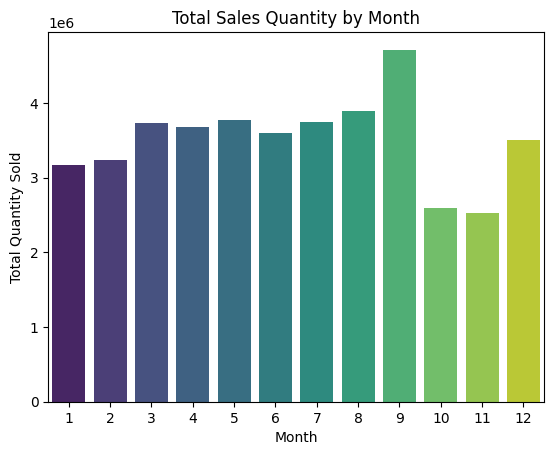

In [7]:
monthly_sales = data.groupby('month')['quantity'].sum().reset_index()

# Plot
sns.barplot(data=monthly_sales, x='month', y='quantity', palette='viridis')
plt.title('Total Sales Quantity by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.show()

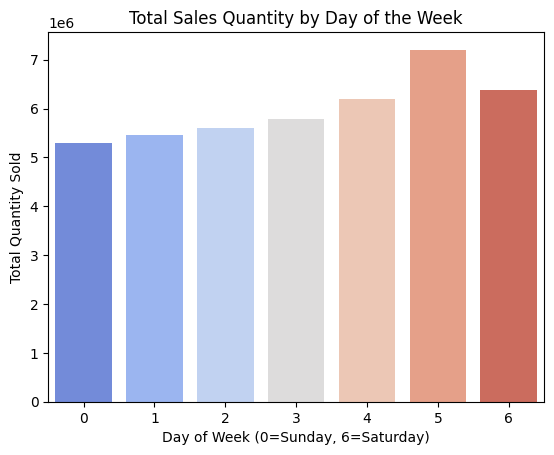

In [64]:
# Group by day_of_week to calculate total sales quantity
day_sales = data.groupby('day_of_week')['quantity'].sum().reset_index()

# Plot
sns.barplot(data=day_sales, x='day_of_week', y='quantity', palette='coolwarm')
plt.title('Total Sales Quantity by Day of the Week')
plt.xlabel('Day of Week (0=Sunday, 6=Saturday)')
plt.ylabel('Total Quantity Sold')
plt.show()

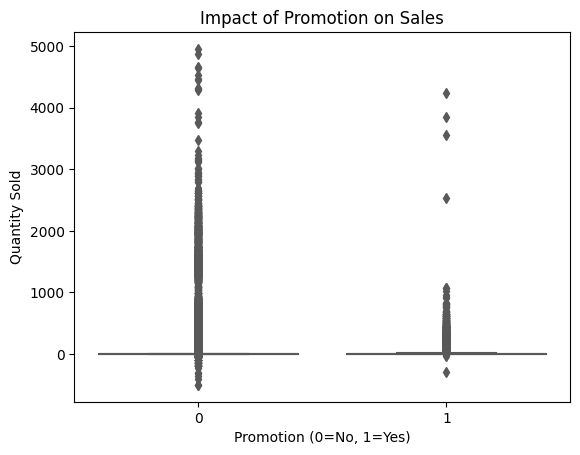

In [65]:
# Boxplot to compare quantity for promotional and non-promotional items
sns.boxplot(data=data, x='is_promo', y='quantity', palette='Set2')
plt.title('Impact of Promotion on Sales')
plt.xlabel('Promotion (0=No, 1=Yes)')
plt.ylabel('Quantity Sold')
plt.show()

In [8]:
promo_stats = data.groupby('is_promo')['quantity'].describe()
print(promo_stats)

              count      mean        std    min  25%  50%    75%     max
is_promo                                                                
0         5933507.0  5.569339  29.638353 -500.0  1.0  2.0  4.000  4952.0
1         1529635.0  5.955963  15.940682 -292.0  1.0  2.0  5.042  4243.0


In [9]:
# Remove negative prices
data = data[data['price'] > 0]

In [68]:
# Remove extreme outliers
#Q1 = data['price'].quantile(0.25)
#Q3 = data['price'].quantile(0.75)
#IQR = Q3 - Q1
#data = data[(data['price'] >= Q1 - 1.5*IQR) & (data['price'] <= Q3 + 1.5*IQR)]

In [83]:
data.dtypes

date                   datetime64[us]
store_id                        int64
item_id                         int64
quantity                      float32
price                         float32
is_promo                        int64
is_markdown                     int64
promo_discount                float32
markdown_percentage           float32
month                           int64
day_of_week                     int64
dept_name                       int64
class_name                      int64
store_format                    int64
city                            int64
quantity_lag1                 float32
quantity_lag7                 float32
rolling_mean_7d               float64
dtype: object

In [10]:
data['price'] = np.log1p(data['price'])

In [11]:
model = Ridge(alpha=1.0)

In [12]:
data.price.min()

0.0099503305

In [13]:
# Add lag features
#data['quantity_lag1'] = data.groupby(['store_id', 'item_id'])['quantity'].shift(1)
#data['quantity_lag7'] = data.groupby(['store_id', 'item_id'])['quantity'].shift(7)

# Add rolling means
#data['rolling_mean_7d'] = data.groupby(['store_id', 'item_id'])['quantity'].transform(
#    lambda x: x.rolling(7, min_periods=1).mean()
#)

# Add price changes
#data['price_change'] = data.groupby(['store_id', 'item_id'])['price'].pct_change()

# Add seasonal features
data['is_weekend'] = (data['day_of_week'].isin([5,6])).astype(int)
data['is_month_end'] = (pd.to_datetime(data['date']).dt.is_month_end).astype(int)
data['promo_price_ratio'] = data['price'] / data.groupby(['item_id'])['price'].transform('mean')


# Add interaction terms
#data['price_promo_interaction'] = data['price'] * data['is_promo']

In [157]:
data

,date,store_id,item_id,quantity,price,is_promo,is_markdown,promo_discount,markdown_percentage,price_change_percentage,month,day_of_week,dept_name,class_name,store_format,city,is_weekend,is_month_end,promo_price_ratio
0,2023-09-14,1,0a832c545a6a,2.000000,4.794964,1,0,27.793219,0.000000,0.000000,9,4,БУМАЖНО-ВАТНАЯ ПРОДУКЦИЯ,БУМАЖНАЯ ПРОДУКЦИЯ,Format-1,City1,0,0,0.951952
1,2023-09-14,1,e034ff8716b5,6.000000,4.081428,1,0,30.030029,0.000000,0.000000,9,4,"ШОКОЛАД,ШОКОЛАДНАЯ ПАСТА",ШОКОЛАД,Format-1,City1,0,0,0.974317
2,2023-09-14,1,e4c10ab64623,7.000000,6.769527,1,0,13.001300,0.000000,0.000000,9,4,"ВОДКА,НАСТОЙКИ",ВОДКА,Format-1,City1,0,0,0.983343
3,2023-09-14,1,324e2e6450c8,23.091999,5.696455,1,0,25.006252,0.000000,0.000000,9,4,КОЛБАСЫ ВАРЕНЫЕ,КОЛБАСА ВАРЕНАЯ,Format-1,City1,0,0,0.972932
4,2023-09-14,1,17dc78090de5,61.000000,2.604170,1,0,15.075377,0.000000,0.000000,9,4,КОФЕ,КОФЕ РАСТВОРИМЫЙ,Format-1,City1,0,0,0.855023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7463137,2022-11-16,2,2ffa9c1bf905,2.000000,5.903043,0,1,0.000000,0.082079,0.095851,11,3,ТОРТЫ,СЛОЕНЫЕ,Format-6,City1,0,0,0.946005
7463138,2022-11-16,2,1dc20c4f962f,2.000000,5.789196,0,1,0.000000,2.847249,-22.486570,11,3,ТОРТЫ,СУФЛЕ,Format-6,City1,0,0,0.974256
7463139,2022-11-16,2,2ffa9c1bf905,2.000000,5.903043,0,1,0.000000,0.082079,0.013693,11,3,ТОРТЫ,СЛОЕНЫЕ,Format-6,City1,0,0,0.946005
7463140,2022-11-16,2,1dc20c4f962f,2.000000,5.789196,0,1,0.000000,2.847249,-22.486570,11,3,ТОРТЫ,СУФЛЕ,Format-6,City1,0,0,0.974256


In [14]:
# Prepare features
def prepare_features(df):
    # Encode categorical variables
    cat_columns = ['dept_name', 'class_name', 'store_format', 'city','item_id','store_id','is_promo','is_markdown']
    label_encoders = {}
    
    for col in cat_columns:
        df[col] = df[col].fillna('Unknown')  # Handle missing values
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    # Fill missing numerical values
    df = df.fillna(0)
    
    return df, label_encoders

In [16]:
# Prepare the data
data, label_encoders = prepare_features(data)

# Split features and target
target = 'quantity'
features = ['price', 'month', 'day_of_week', 'dept_name', 'class_name', 
            'store_format', 'city', 'store_id', 'item_id','is_promo','is_markdown',
            'is_weekend','is_month_end','price_change_percentage']

X = data[features]
y = data[target]

# Split train/test based on date
split_date = '2024-06-01'  # adjust based on your data
train_mask = pd.to_datetime(data['date']) < split_date
X_train = X[train_mask]
X_test = X[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]


# Train model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=14,
    random_state=42,
    #enable_categorical=True
)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

### Testing model #2
* Took much longer to train and had lower performance 

In [110]:
from sklearn.ensemble import GradientBoostingRegressor
model_GBR = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model_GBR.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [18]:
# Evaluate
y_pred = model.predict(X_test)
print("\nModel Evaluation Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")


Model Evaluation Metrics:
RMSE: 19.67
MAE: 3.21
R2 Score: 0.60


In [161]:
X_train.shape

(5845557, 14)

In [162]:
X_test.shape

(1609444, 14)

* Feature importance show that store_format, item_id, class_name, dept_name
are the most important features

In [19]:
# Show feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
})
print("\nFeature Importance:")
print(importance.sort_values('importance', ascending=False))


Feature Importance:
                    feature  importance
5              store_format    0.363559
8                   item_id    0.200288
4                class_name    0.196654
3                 dept_name    0.106583
0                     price    0.049938
9                  is_promo    0.035164
2               day_of_week    0.015545
12             is_month_end    0.010292
13  price_change_percentage    0.007791
1                     month    0.007230
10              is_markdown    0.006957
6                      city    0.000000
7                  store_id    0.000000
11               is_weekend    0.000000
